# Dataset Exploration and Analysis

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pprint
import os
import glob
import re

### Dense Dataset
in HDF5 format (Range Image). 
Directly used by original WeatherNet. Contain Pointwise labels.
- **Keys**: `sensorX_1`, `sensorY_1`, `sensorZ_1`, `intensity_1`, `distance_m_1`, `labels_1`
- **Shape**: (beams, azimuths) = (32, 400)
- **Attrs**: `dateStr`, `timeStr`, `meteorologicalVisibility_m`, `rainfallRate_mmh`, `ros2pcd_time`
- **Labels**: 0, 100 (clear), 101 (rain), 102（fog)

In [3]:
# filepath = '/home/ubuntu/workspace/weather_clutter_detection/dataset/dense/train_01/2018-11-29_145021_Static1-Day-Clear/LidarImage_000000012.hdf5'
filepath = '/home/ubuntu/workspace/weather_clutter_detection/dataset/dense/train_01/2018-11-29_154253_Static1-Day-Rain15/LidarImage_000000004.hdf5'

with h5py.File(filepath, "r", driver='core') as f:
    weather_data = dict(f.attrs)
    print("Metadata of this log:", weather_data)
    print("Keys of dataset:", list(f.keys()))

    x = f["sensorX_1"][:]
    y = f["sensorY_1"][:]
    z = f["sensorZ_1"][:]
    intensity = f["intensity_1"][:]
    labels = f["labels_1"][:]
    distance = f["distance_m_1"][:]

    print("Shape of dataset (beams, azimuths):", x.shape)  # (32, 400)

    beam, az = 0, 0
    pt1 = (x[beam, az], y[beam, az], z[beam, az], intensity[beam, az], labels[beam, az])
    print(f"Point 1 (beam {beam}, azimuth {az}): x={x[beam,az]:.2f}, y={y[beam,az]:.2f}, z={z[beam,az]:.2f}, intensity={intensity[beam,az]:.2f}, label={labels[beam,az]:.0f}")
    beam, az = 0, 1
    pt2 = (x[beam, az], y[beam, az], z[beam, az], intensity[beam, az], labels[beam, az])
    print(f"Point 2 (beam {beam}, azimuth {az}): x={x[beam,az]:.2f}, y={y[beam,az]:.2f}, z={z[beam,az]:.2f}, intensity={intensity[beam,az]:.2f}, label={labels[beam,az]:.0f}")

    unique_labels = np.unique(labels)
    print("Unique labels in this log (within 0, 100, 101, 102):", unique_labels)

    rain_points = np.isin(labels, [101, 102])
    print(f"Percentage of rain points: {np.mean(rain_points) * 100:.2f}%")




Metadata of this log: {'dateStr': b'2018-11-29', 'meteorologicalVisibility_m': 68.0, 'rainfallRate_mmh': 15.0, 'ros2pcd_time': 1543502579669882, 'timeStr': b'154253'}
Keys of dataset: ['distance_m_1', 'intensity_1', 'labels_1', 'sensorX_1', 'sensorY_1', 'sensorZ_1']
Shape of dataset (beams, azimuths): (32, 400)
Point 1 (beam 0, azimuth 0): x=3.34, y=2.80, z=1.17, intensity=0.00, label=100
Point 2 (beam 0, azimuth 1): x=2.54, y=2.11, z=0.89, intensity=0.00, label=100
Unique labels in this log (within 0, 100, 101, 102): [  0 100 101]
Percentage of rain points: 35.90%


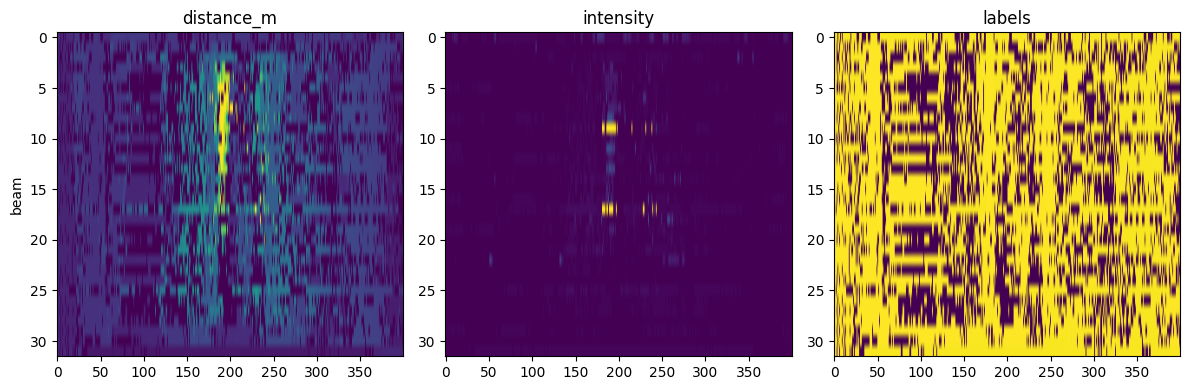

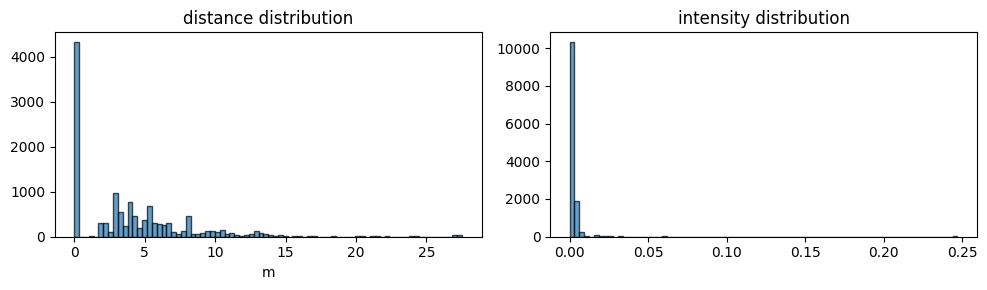

Distance: min=0.00, max=27.54, mean=4.04
Intensity: min=0.0000, max=0.2471, mean=0.0019


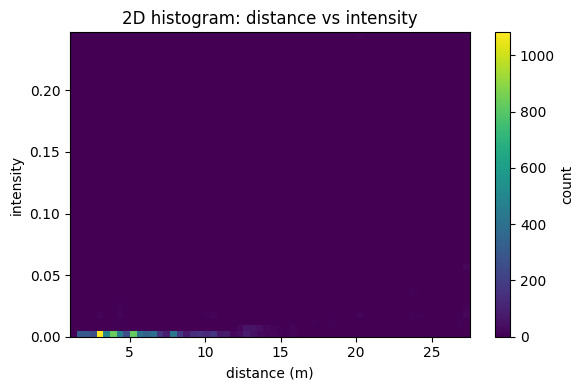

Label counts: {0: 4326, 100: 3879, 101: 4595}
  label 0: 33.8%
  label 100: 30.3%
  label 101: 35.9%


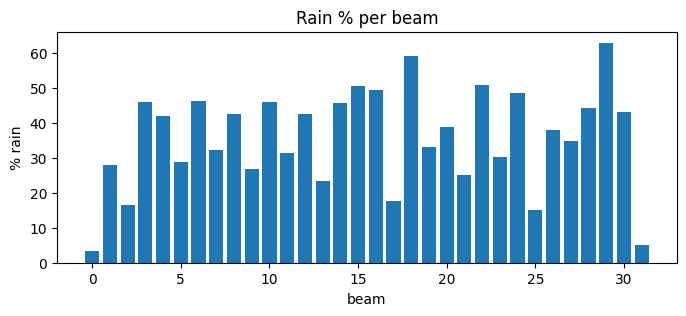

In [4]:
# range image. histogram for distance and intensity
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(distance, aspect="auto"); axes[0].set_title("distance_m"); axes[0].set_ylabel("beam")
axes[1].imshow(intensity, aspect="auto"); axes[1].set_title("intensity")
axes[2].imshow(labels, aspect="auto"); axes[2].set_title("labels")
plt.tight_layout(); plt.show()

# distribution
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].hist(distance.ravel(), bins=80, edgecolor="k", alpha=0.7); ax[0].set_title("distance distribution"); ax[0].set_xlabel("m")
ax[1].hist(intensity.ravel(), bins=80, edgecolor="k", alpha=0.7); ax[1].set_title("intensity distribution")
plt.tight_layout(); plt.show()
print("Distance: min={:.2f}, max={:.2f}, mean={:.2f}".format(float(np.nanmin(distance)), float(np.nanmax(distance)), float(np.nanmean(distance))))
print("Intensity: min={:.4f}, max={:.4f}, mean={:.4f}".format(float(np.nanmin(intensity)), float(np.nanmax(intensity)), float(np.nanmean(intensity))))

# distance vs intensity
d_flat = distance.ravel()
i_flat = intensity.ravel()
valid = np.isfinite(d_flat) & np.isfinite(i_flat) & (d_flat > 0)
d_flat, i_flat = d_flat[valid], i_flat[valid]
plt.figure(figsize=(6, 4))
plt.hist2d(d_flat, i_flat, bins=(60, 50), cmap="viridis")
plt.colorbar(label="count")
plt.xlabel("distance (m)"); plt.ylabel("intensity"); plt.title("2D histogram: distance vs intensity")
plt.tight_layout(); plt.show()

# label counts and percentage
ul, counts = np.unique(labels.ravel(), return_counts=True)
print("Label counts:", dict(zip(ul.tolist(), counts.tolist())))
for u, c in zip(ul, counts):
    print("  label {}: {:.1f}%".format(u, 100 * c / labels.size))

# rain/fog percentage per beam
rain = np.isin(labels, [101, 102])
rain_per_beam = rain.sum(axis=1) / labels.shape[1]
plt.figure(figsize=(8, 3)); plt.bar(range(len(rain_per_beam)), rain_per_beam * 100); plt.xlabel("beam"); plt.ylabel("% rain"); plt.title("Rain % per beam"); plt.show()

### CADC Dataset

- **Format**: `.bin` (Velodyne-style raw binary). Used by LiSnowNet. No pointwise labels in the .bin; LiSnowNet does not use labels.
- **Layout**: `{date}/{drive}/` e.g. `2018_03_06/0002/`
  - `3d_ann.json` — per-frame 3D cuboid annotations (Car, Truck, etc.; object-level, not point-level).
  - `labeled/lidar_points/data/*.bin` — point clouds.
  - `labeled/lidar_points/timestamps.txt` — one timestamp per frame.
  - `labeled/image_00/`, `image_02/`, … — cameras (optional).
- **.bin content**: `float32`, shape `(N, 4)` per frame: **x, y, z, intensity** (sensor frame). N varies (~40k–80k typical). Intensity in [0, 1].
- **Sensor**: 32-beam (VLP-32C–style); beam inclinations in `lisnownet/tools/datasets/cadc.py`.


Shape (N, 4): (41730, 4)
Point 1 (first 3 pts, 2 decimals): [[-4.600e+00 -1.510e+00 -2.210e+00  7.000e-02]
 [-3.096e+01 -1.039e+01 -9.500e-01  1.000e-02]
 [-7.290e+00 -2.820e+00 -2.160e+00  5.000e-02]]
Distance: min=0.89, max=199.51, mean=47.17 m
Intensity: min=0.0000, max=1.0000, mean=0.0613


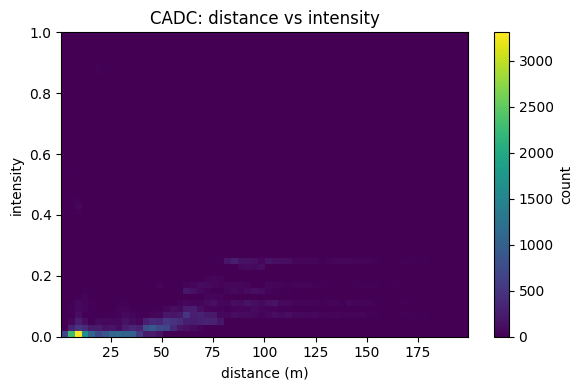

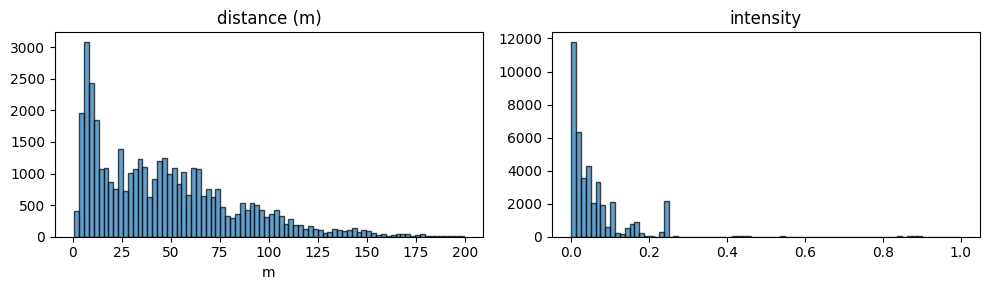

In [5]:
# CADC: pick a .bin (use a drive that has labeled/lidar_points/data/*.bin, e.g. 0002)
filepath = "/home/ubuntu/workspace/weather_clutter_detection/dataset/cadc/cadcd/2018_03_06/0002/labeled/lidar_points/data/0000000000.bin"

points = np.fromfile(filepath, dtype=np.float32).reshape(-1, 4)
x, y, z = points[:, 0], points[:, 1], points[:, 2]
intensity = points[:, 3]
distance = np.linalg.norm(points[:, :3], axis=1)

print("Shape (N, 4):", points.shape)
print("Point 1 (first 3 pts, 2 decimals):", np.round(points[:3], 2))
print("Distance: min={:.2f}, max={:.2f}, mean={:.2f} m".format(distance.min(), distance.max(), distance.mean()))
print("Intensity: min={:.4f}, max={:.4f}, mean={:.4f}".format(intensity.min(), intensity.max(), intensity.mean()))

# 2D histogram: distance vs intensity
valid = np.isfinite(distance) & np.isfinite(intensity) & (distance > 0)
d_flat, i_flat = distance[valid], intensity[valid]
plt.figure(figsize=(6, 4))
plt.hist2d(d_flat, i_flat, bins=(60, 50), cmap="viridis")
plt.colorbar(label="count")
plt.xlabel("distance (m)"); plt.ylabel("intensity"); plt.title("CADC: distance vs intensity")
plt.tight_layout(); plt.show()

# 1D distributions
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].hist(distance, bins=80, edgecolor="k", alpha=0.7); ax[0].set_title("distance (m)"); ax[0].set_xlabel("m")
ax[1].hist(intensity, bins=80, edgecolor="k", alpha=0.7); ax[1].set_title("intensity")
plt.tight_layout(); plt.show()

### WADS Dataset (note)

- **Format**: SemanticKITTI-style. One `.bin` (point cloud) + one `.label` (pointwise labels) per frame. Used by LiSnowNet; **has pointwise semantic labels** (including snow).
- **Layout**: `{data_root}/{seq}/` e.g. `11_20211109T212945Z_001/11/`
  - `velodyne/*.bin` — point clouds; `labels/*.label` — one int32 per point (same frame ID, e.g. 039498.bin ↔ 039498.label).
  - `poses.txt`, `calib.txt`, `instances.txt`, `README.md`.
- **.bin**: `float32` (N, 4) = x, y, z, intensity (0–255 in file; loader uses `/255`). Duplicates removed via `np.unique`; labels indexed by same order.
- **.label**: `int32`, SemanticKITTI IDs (e.g. falling_snow, accumulated_snow + standard classes).
- **Sensor**: 64-beam, width 2048 (`lisnownet/tools/datasets/wads.py`).


Shape (N, 4): (115881, 4)
First 2 points (x,y,z,intensity): [[-1.9785e+02  2.6660e+01  3.9900e+00  5.0000e-02]
 [-1.9779e+02  2.5840e+01  2.8100e+00  2.0000e-02]]
Distance: min=0.30, max=199.68, mean=27.62 m
Intensity: min=0.0000, max=1.0000, mean=0.0486
Label IDs (SemanticKITTI + snow): {0: 10722, 10: 1955, 13: 2013, 18: 9213, 30: 88, 40: 17248, 48: 5178, 49: 35, 50: 34847, 51: 1895, 52: 8, 70: 1382, 80: 404, 81: 2543, 99: 131, 110: 14276, 111: 13943}
  0: 10722 (unlabeled)
  10: 1955 (car)
  13: 2013 (bus)
  18: 9213 (truck)
  30: 88 (person)
  40: 17248 (road)
  48: 5178 (sidewalk)
  49: 35 (other-ground)
  50: 34847 (building)
  51: 1895 (fence)
  52: 8 (other-structure)
  70: 1382 (vegetation)
  80: 404 (pole)
  81: 2543 (traffic-sign)
  99: 131 (other-object)
  110: 14276 (falling_snow)
  111: 13943 (accumulated_snow)
Weather artifact points (falling_snow + accumulated_snow): 28219 (24.35%)


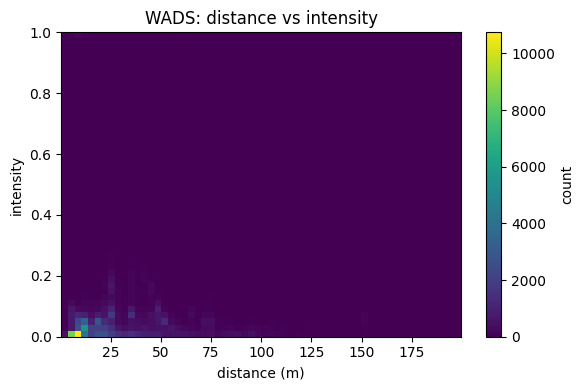

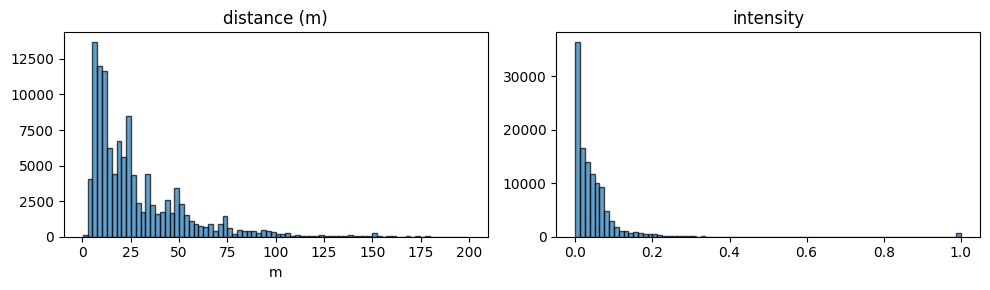

In [6]:
# WADS: pick a .bin (same frame ID for .label)
filepath = "/home/ubuntu/workspace/weather_clutter_detection/dataset/wads/11_20211109T212945Z_001/11/velodyne/039498.bin"

points = np.fromfile(filepath, dtype=np.float32).reshape(-1, 4)
points, idx_unique = np.unique(points, axis=0, return_index=True)
points = points.copy()
points[:, -1] /= 255

label_path = filepath.replace("velodyne", "labels").replace(".bin", ".label")
labels = np.fromfile(label_path, dtype=np.int32)[idx_unique]

x, y, z = points[:, 0], points[:, 1], points[:, 2]
intensity = points[:, 3]
distance = np.linalg.norm(points[:, :3], axis=1)

print("Shape (N, 4):", points.shape)
print("First 2 points (x,y,z,intensity):", np.round(points[:2], 2))
print("Distance: min={:.2f}, max={:.2f}, mean={:.2f} m".format(distance.min(), distance.max(), distance.mean()))
print("Intensity: min={:.4f}, max={:.4f}, mean={:.4f}".format(intensity.min(), intensity.max(), intensity.mean()))
ul, counts = np.unique(labels, return_counts=True)
print("Label IDs (SemanticKITTI + snow):", dict(zip(ul.tolist(), counts.tolist())))

# ID -> name (SemanticKITTI + WADS extensions). Weather artifacts: 110 = falling_snow, 111 = accumulated_snow; 99 = other-object (optional)
WADS_LABEL_NAMES = {0: "unlabeled", 1: "outlier", 10: "car", 11: "bicycle", 13: "bus", 15: "motorcycle", 16: "on-rails", 18: "truck", 20: "other-vehicle", 30: "person", 31: "bicyclist", 32: "motorcyclist", 40: "road", 44: "parking", 48: "sidewalk", 49: "other-ground", 50: "building", 51: "fence", 52: "other-structure", 60: "lane-marking", 70: "vegetation", 71: "trunk", 72: "terrain", 80: "pole", 81: "traffic-sign", 99: "other-object", 110: "falling_snow", 111: "accumulated_snow"}
WEATHER_LABEL_IDS = (110, 111)  # falling_snow, accumulated_snow
for lid, c in zip(ul, counts):
    print("  {}: {} ({})".format(int(lid), int(c), WADS_LABEL_NAMES.get(int(lid), "?")))
weather_mask = np.isin(labels, WEATHER_LABEL_IDS)
n_weather = weather_mask.sum()
print("Weather artifact points (falling_snow + accumulated_snow): {} ({:.2f}%)".format(int(n_weather), 100 * n_weather / len(labels)))

# 2D histogram: distance vs intensity
valid = np.isfinite(distance) & np.isfinite(intensity) & (distance > 0)
plt.figure(figsize=(6, 4))
plt.hist2d(distance[valid], intensity[valid], bins=(60, 50), cmap="viridis")
plt.colorbar(label="count")
plt.xlabel("distance (m)"); plt.ylabel("intensity"); plt.title("WADS: distance vs intensity")
plt.tight_layout(); plt.show()

# 1D distributions
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].hist(distance, bins=80, edgecolor="k", alpha=0.7); ax[0].set_title("distance (m)"); ax[0].set_xlabel("m")
ax[1].hist(intensity, bins=80, edgecolor="k", alpha=0.7); ax[1].set_title("intensity")
plt.tight_layout(); plt.show()


### GLYD Data

- **Format**: Velodyne-style .bin (one file per frame). No pointwise labels.
- **Layout**: Flat list of `*.bin` (e.g. `glyd_snow_1run_bin/001320.bin`).
- **.bin content**: `float32`, shape `(N, 4)`

- **Lidar**: Treated as **VLP-32C / 32-beam** in codebase. For range-image conversion use **rows=32**, **cols=400** or **2048**.
- **Exploration**: Load raw, infer cols_per_pt (4 or 5), then `reshape(-1, cols_per_pt)[:, :4]` for x,y,z,intensity.


Floats: 235596, cols_per_pt: 4 -> shape (58899, 4)
First 2 points (x,y,z,intensity): [[33.18 53.81 -2.33  0.39]
 [24.93 43.33 -2.71  0.78]]
Distance: min=7.03, max=207.03, mean=24.11 m
Intensity: min=0.0000, max=100.0000, mean=2.9811


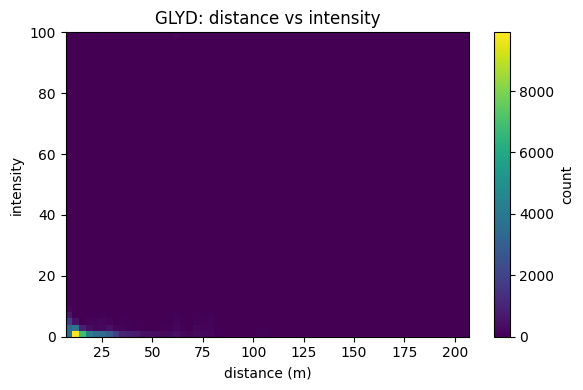

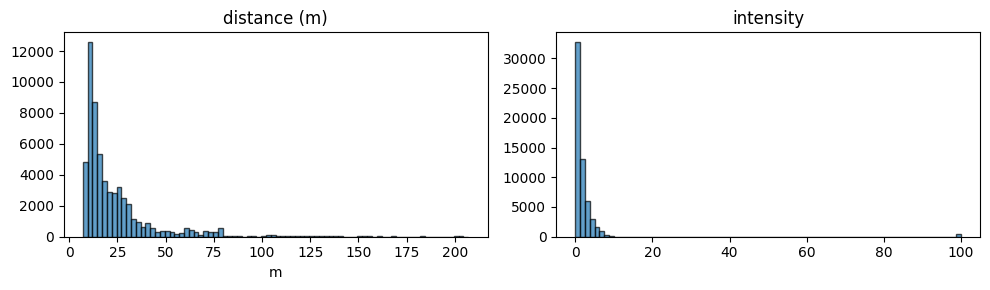

In [ ]:
# GLYD: one example (no labels). Infer (N, 4) vs (N, 5) from file size.
filepath = "/home/ubuntu/workspace/weather_clutter_detection/dataset/glyd/glyd_snow_1run_bin/001320.bin"
raw = np.fromfile(filepath, dtype=np.float32)
n_floats = len(raw)


points = raw.reshape(-1, 4)[:, :4] # (N, 4)

x, y, z = points[:, 0], points[:, 1], points[:, 2]
intensity = points[:, 3]
distance = np.linalg.norm(points[:, :3], axis=1)

print("First 2 points (x,y,z,intensity):", np.round(points[:2], 2))
print("Distance: min={:.2f}, max={:.2f}, mean={:.2f} m".format(distance.min(), distance.max(), distance.mean()))
print("Intensity: min={:.4f}, max={:.4f}, mean={:.4f}".format(intensity.min(), intensity.max(), intensity.mean()))

# 2D histogram: distance vs intensity
valid = np.isfinite(distance) & np.isfinite(intensity) & (distance > 0)
plt.figure(figsize=(6, 4))
plt.hist2d(distance[valid], intensity[valid], bins=(60, 50), cmap="viridis")
plt.colorbar(label="count")
plt.xlabel("distance (m)"); plt.ylabel("intensity"); plt.title("GLYD: distance vs intensity")
plt.tight_layout(); plt.show()

# 1D distributions
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].hist(distance, bins=80, edgecolor="k", alpha=0.7); ax[0].set_title("distance (m)"); ax[0].set_xlabel("m")
ax[1].hist(intensity, bins=80, edgecolor="k", alpha=0.7); ax[1].set_title("intensity")
plt.tight_layout(); plt.show()


### Lidar settings: DENSE vs CADC vs WADS vs GLYD (from codebase)

| Dataset | Format | Beams (rows) | Azimuth (cols) | Source | .bin content |
|---------|--------|--------------|----------------|--------|-------------|
| **DENSE** | HDF5 | 32 | 400 | WeatherNet/visu | N/A (pre-projected) |
| **CADC** | .bin | 32 (VLP-32C) | 2048 (LiSnowNet width) | `lisnownet/tools/datasets/cadc.py` INC, WIDTH | (N,4) float32: x,y,z,intensity |
| **WADS** | .bin + .label | 64 (HDL-64 style) | 2048 | `lisnownet/tools/datasets/wads.py` INC, WIDTH | (N,4) float32: x,y,z,intensity (0–255); labels int32 |
| **GLYD** | .bin | 32 (VLP-32C) | configurable (e.g. 400 or 2048) | `dynamic_driver_loader.cc` in Glyd repo and `custom_bin.py` | (N,4) float32: x,y,z,intensity; no labels |

Range image conversion (e.g. `velodyne_bin_to_hdf5.py`) uses configurable **rows** and **cols** (default 32×400 to match DENSE). Row assignment is by elevation angle (phi); col by azimuth (theta).

======== Archive =============